# Homework #3 - Rossman Store Sales

Importing all the dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import math
import csv
import xgboost
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


`feature_list` is going to be the dataframe that contains our features. This is so that we don't contaminate our training data

In [2]:
feature_list = pd.DataFrame()

Load training data and merge it with the store data. We also omit all stores that are closed for training

In [3]:
trainData = pd.read_csv('train_v2.csv', parse_dates=['Date'], dtype={'StateHoliday': 'str'})
testData = pd.read_csv('test_v2.csv',  parse_dates=['Date'], dtype={'StateHoliday': 'str'})
storeData = pd.read_csv('store.csv')
trainData = pd.merge(trainData, storeData, on="Store")
testData = testData.reset_index().merge(storeData,on='Store')
index = testData['index']
testData.drop('index', axis=1, inplace=True)
trainData = trainData[trainData.Customers != 0]

## Feature 1: Linear Regression Prediction Solely Based on Customers

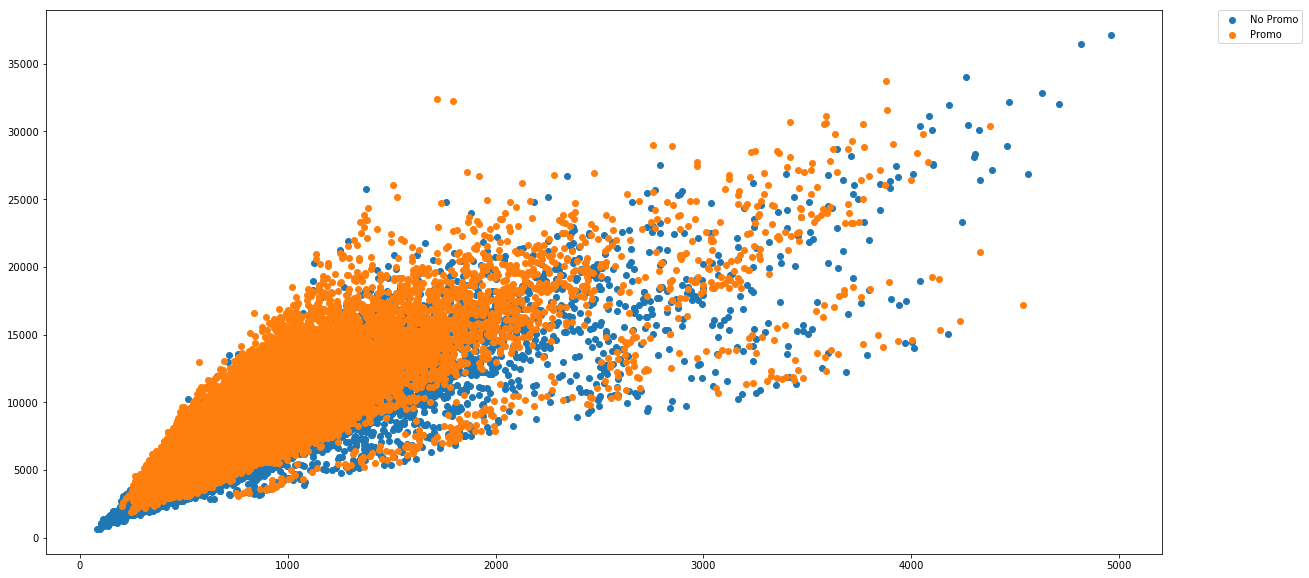

In [4]:
pl.figure(figsize=(20,10))
pl.scatter(trainData[trainData.Promo == 0].Customers, trainData[trainData.Promo == 0].Sales, label="No Promo")
pl.scatter(trainData[trainData.Promo == 1].Customers, trainData[trainData.Promo == 1].Sales, label="Promo")
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.show()

As we can see, there is a strong pattern between customers and sales. We can do a linear regression and add it into one of our features

In [5]:
# Feature 1: Sales-customer relationship of a store
X = trainData.Customers.values.reshape(-1,1)
y = trainData.Sales.values.reshape(-1,1)
sales_customer_lr = LinearRegression()
sales_customer_lr.fit(X,y)
df = pd.DataFrame(sales_customer_lr.predict(X))
feature_list["sales_customer"] = df[0]

## Feature 2: Median of a particular store

While the first feature shows the general trend of all the stores, we need to have a centrality measure to make sure the prediction is correct not only on the trend, but also accurate on the numbers. We therefore include the median of the store

In [6]:
# Feature 2: Median of a store
medianOfStore = trainData.groupby("Store").median().Sales
def getMedianOfStore(row):
    return medianOfStore.iloc[row["Store"] - 1]
df = pd.DataFrame()
df["store_median"] = trainData[trainData.Customers != 0].apply(lambda row: getMedianOfStore(row), axis=1)
df.index = range(len(df))
feature_list["store_median"] = df["store_median"]

## Feature 3: Median sales of a weekday
We further determine that there are different sales medians depending on the day of the week

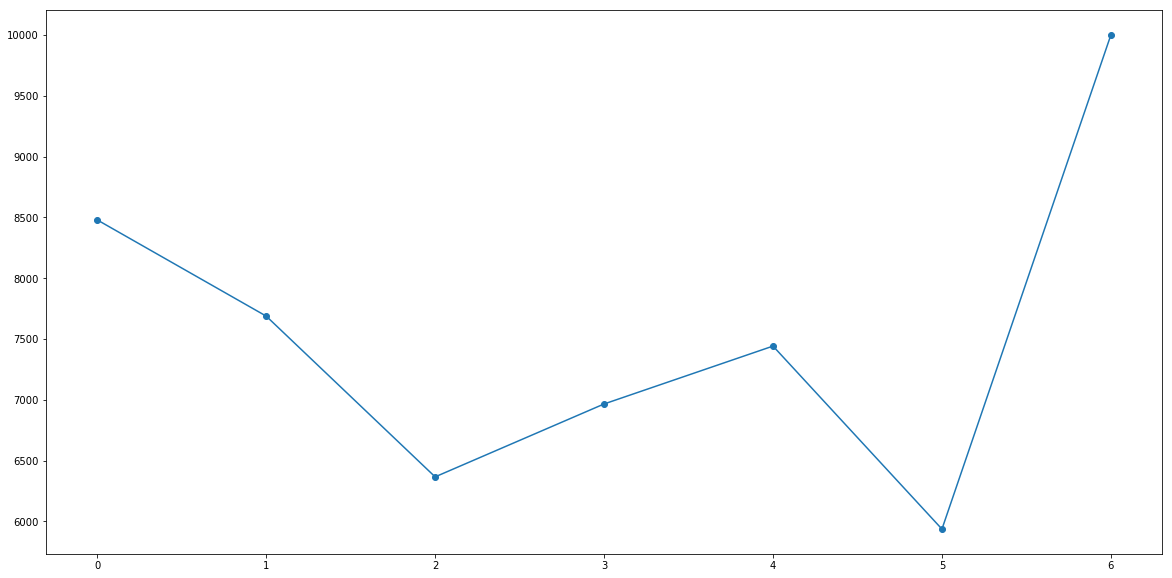

In [7]:
def getWeekDay(row):
    return row["Date"].weekday()
_trainData = pd.DataFrame()
_trainData["Sales"] = trainData["Sales"]
_trainData["Weekday"] = trainData.apply(lambda row: getWeekDay(row), axis=1)
medianOfWeekday = _trainData.groupby("Weekday").median().Sales
pl.figure(figsize=(20,10))
pl.scatter(range(7), medianOfWeekday)
pl.plot(range(7), medianOfWeekday)
pl.show()

This shows that there is a strong trend on weekday. We can actually fit a curve with degree 3 to predict median. However, we believe a discrete version is good enough

In [8]:
# Feature 3: Median of a weekday
def getWeekDayMedian(row):
    return medianOfWeekday.iloc[row["Weekday"]]
_trainData["weekday_median"] = _trainData.apply(lambda row: getWeekDayMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["weekday_median"] = _trainData["weekday_median"]

## Feature 4: Median sales with/without promotion
We check if there is change in sales during/ not during promotion

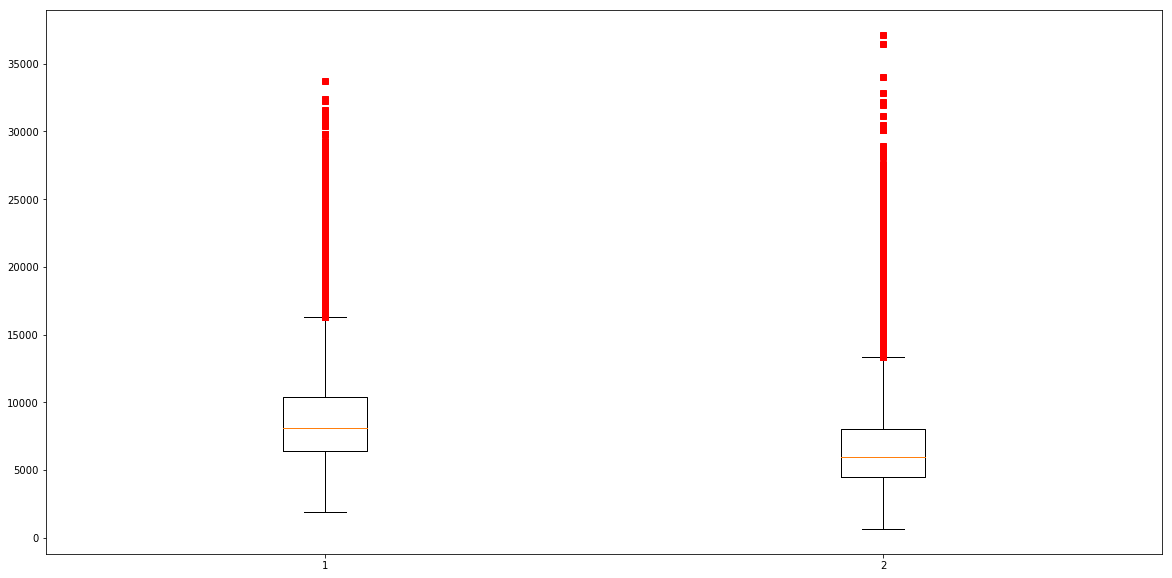

In [9]:
data_promo = trainData[trainData["Promo"] == 1].Sales.as_matrix()
data_no_promo = trainData[trainData["Promo"] == 0].Sales.as_matrix()
pl.figure(figsize=(20,10))

pl.boxplot([x for x in [data_promo, data_no_promo]], 0, 'rs', 1)
pl.show()

There is a slight difference between promotion and no promotion

In [10]:
# Feature 4: Median Sales with/out promo
medianSalesPromo = trainData.groupby("Promo").Sales.median()
def getPromoMedian(row):
    return medianSalesPromo.iloc[row["Promo"]]
_trainData = pd.DataFrame()
_trainData["promo_median_sales"] = trainData.apply(lambda row: getPromoMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["promo_median_sales"] = _trainData["promo_median_sales"]

## Feature 5: Median sales from store type
Let's see if there is any difference between store types

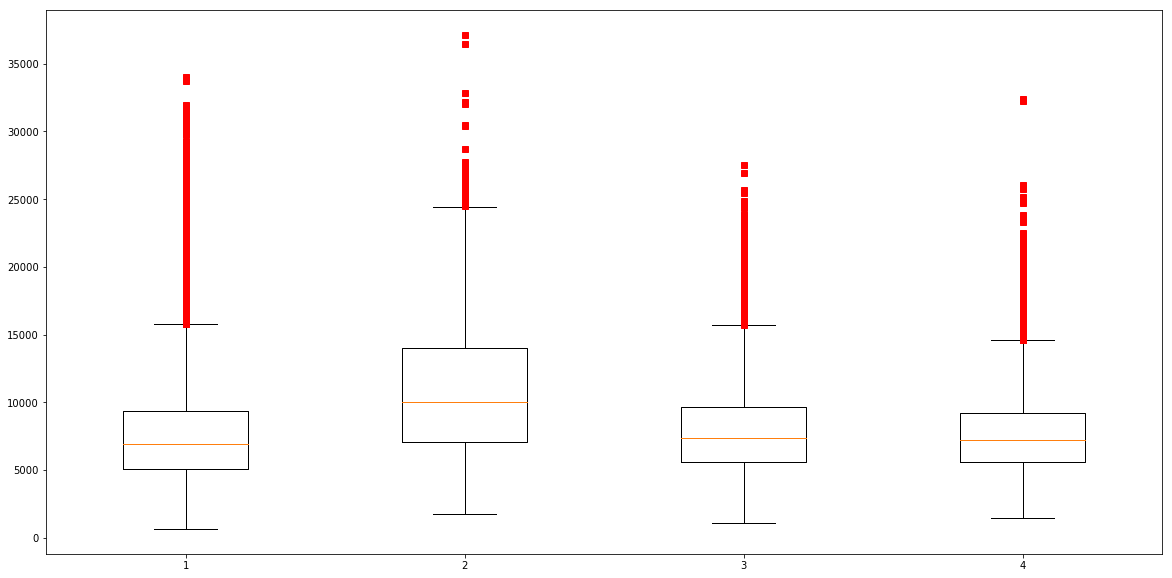

In [11]:
data_a = trainData[trainData["StoreType"] == "a"].Sales.as_matrix()
data_b = trainData[trainData["StoreType"] == "b"].Sales.as_matrix()
data_c = trainData[trainData["StoreType"] == "c"].Sales.as_matrix()
data_d = trainData[trainData["StoreType"] == "d"].Sales.as_matrix()
pl.figure(figsize=(20,10))

pl.boxplot([x for x in [data_a, data_b, data_c, data_d]], 0, 'rs', 1)
pl.show()

It seems like Store Type B has a higher median than others, while store type a,c,d doesn't differ much

In [12]:
# Feature 5: Median sales from store type
storeTypeMedian = trainData.groupby("StoreType").Sales.median()
storeTypeToLoc = {"a":0,"b":1,"c":2,"d":3}
def getStoreTypeMedian(row):
    return storeTypeMedian.iloc[storeTypeToLoc[row["StoreType"]]]
_trainData = pd.DataFrame()
_trainData["store_type_median"] = trainData.apply(lambda row: getStoreTypeMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["store_type_median"] = _trainData["store_type_median"]

## Feature 6: Median sales from assortment
We check if there is any difference in assortment as well

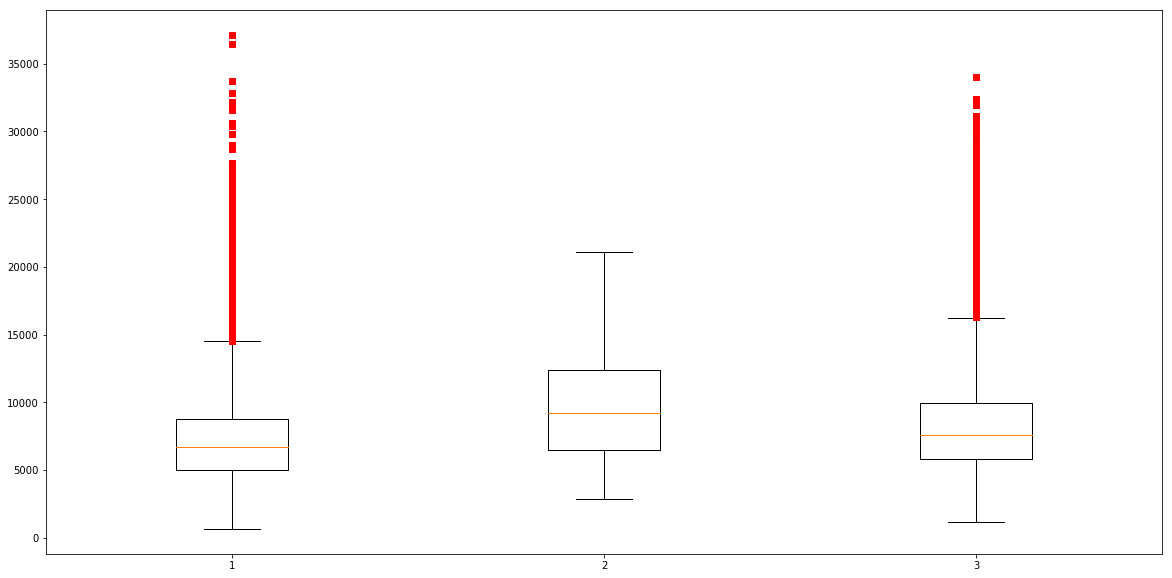

In [13]:
data_a = trainData[trainData["Assortment"] == "a"].Sales.as_matrix()
data_b = trainData[trainData["Assortment"] == "b"].Sales.as_matrix()
data_c = trainData[trainData["Assortment"] == "c"].Sales.as_matrix()
pl.figure(figsize=(20,10))

pl.boxplot([x for x in [data_a, data_b, data_c]], 0, 'rs', 1)
pl.show()

In [14]:
# Feature 6: Median sales from assortment
assortmentMedian = trainData.groupby("Assortment").Sales.median()
storeAssortmentToLoc = {"a":0,"b":1,"c":2}
def getAssortmentMedian(row):
    return assortmentMedian.iloc[storeAssortmentToLoc[row["Assortment"]]]
_trainData = pd.DataFrame()
_trainData["assortment_median"] = trainData.apply(lambda row: getAssortmentMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["assortment_median"] = _trainData["assortment_median"]

## Feature 7: Competition
We also add competition into the feature list

In [15]:
# Feature 7: Competition
feature_list["competition_distance"] = trainData["CompetitionDistance"]
feature_list.fillna(0, inplace=True)

## Feature 8: Median sales for holiday
We think that holiday might also be influential to the sales

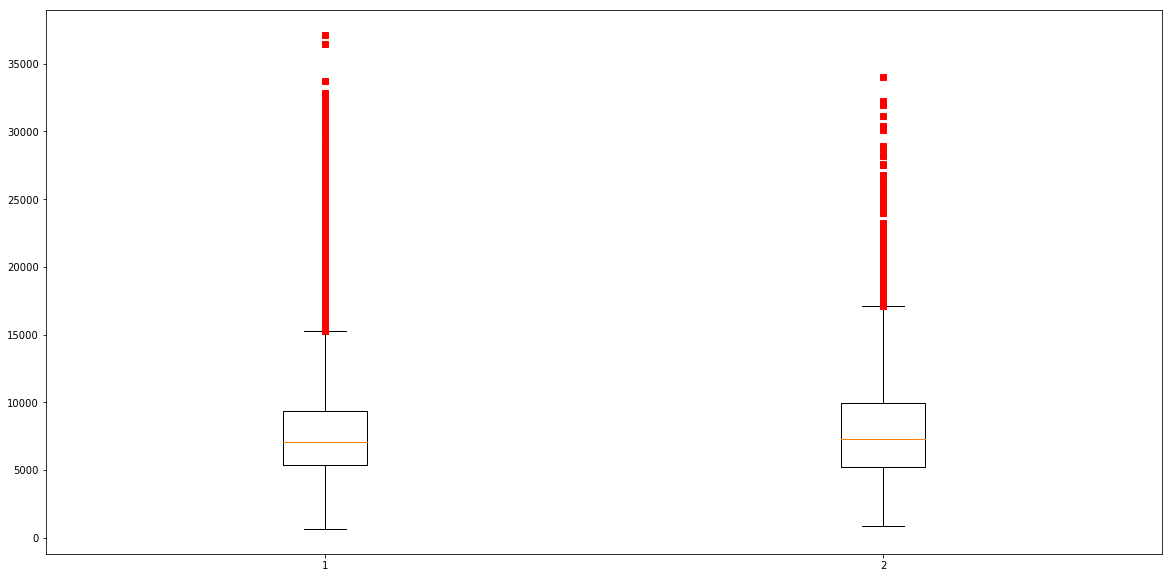

In [16]:
def hasHoliday(row):
    if row["StateHoliday"] == "0" and row["SchoolHoliday"] == 0:
        return 0
    else:
        return 1

_trainData = pd.DataFrame()
_trainData["Holiday"] = trainData.apply(lambda row: hasHoliday(row), axis=1)
_trainData["Sales"] = trainData["Sales"]
data_no_holiday = _trainData[_trainData["Holiday"] == 0].Sales.as_matrix()
data_holiday = _trainData[_trainData["Holiday"] == 1].Sales.as_matrix()
pl.figure(figsize=(20,10))

pl.boxplot([x for x in [data_no_holiday, data_holiday]], 0, 'rs', 1)
pl.show()

It does not seem that it has much difference, but we'll just add it in to enrich the features

In [17]:
# Feature 8: Median sales for holiday
holidayMedian = _trainData.groupby("Holiday").Sales.median()
def getHolidayMedian(row):
    return holidayMedian.iloc[row["Holiday"]]
_trainData["holiday_median"] = _trainData.apply(lambda row: getHolidayMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["holiday_median"] = _trainData["holiday_median"]

## Feature 9: Median sales for holiday that is between the current day
We think there might be other relationships with holidays

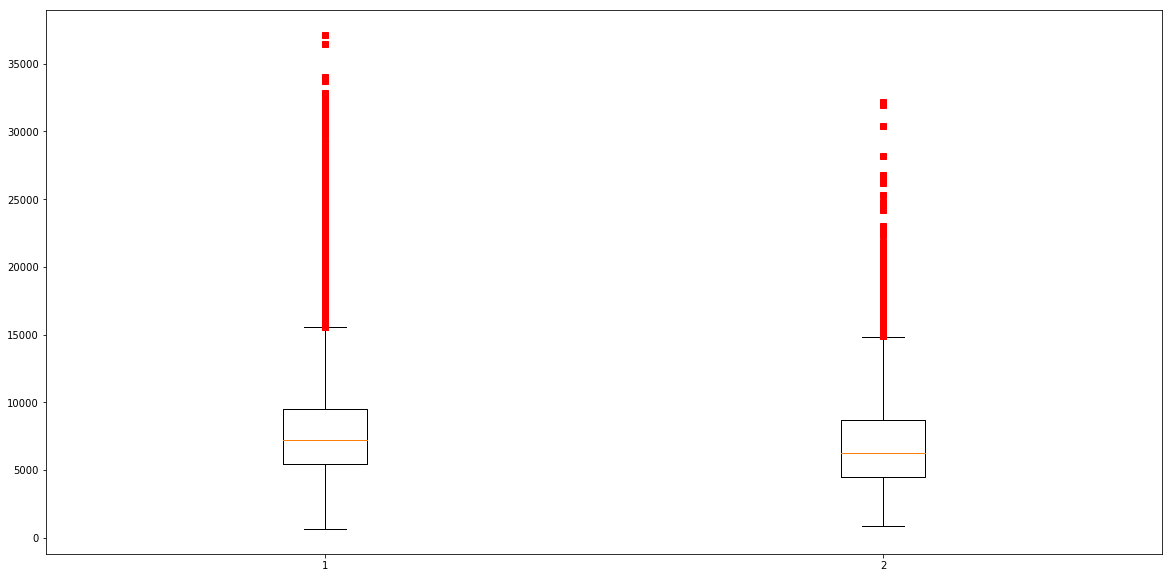

In [18]:
def isTomorrowHoliday(row):
    current = row['isTomorrowHoliday']
    if (row['Date'].to_pydatetime() + timedelta(1) == row['previousRowDate']):
        return int(current)
    else:
        return 0
def isYesterdayHoliday(row):
    current = row['isYesterdayHoliday']
    if (row['Date'].to_pydatetime() - timedelta(1) == row['nextRowDate']):
        return int(current)
    else:
        return 0
_trainData = pd.DataFrame()
_trainData["Holiday"] = trainData.apply(lambda row: hasHoliday(row), axis=1)
_trainData["Sales"] = trainData["Sales"]
_trainData["Date"] = trainData["Date"]
_trainData['previousRowDate'] = _trainData['Date'].shift(1)
_trainData['nextRowDate'] = _trainData['Date'].shift(-1)
_trainData['isTomorrowHoliday'] = _trainData['Holiday'].shift(1)
_trainData['isYesterdayHoliday'] = _trainData['Holiday'].shift(-1)
_trainData['isTomorrowHoliday'] = _trainData.apply(lambda row: isTomorrowHoliday(row), axis=1)
_trainData['isYesterdayHoliday'] = _trainData.apply(lambda row: isYesterdayHoliday(row), axis=1)
data_previous_no_holiday = _trainData[_trainData["isYesterdayHoliday"] == 0].Sales.as_matrix()
data_previous_holiday = _trainData[_trainData["isYesterdayHoliday"] == 1].Sales.as_matrix()
pl.figure(figsize=(20,10))

pl.boxplot([x for x in [data_previous_no_holiday, data_previous_holiday]], 0, 'rs', 1)
pl.show()

It does not seem there is much difference if yesterday is a holiday

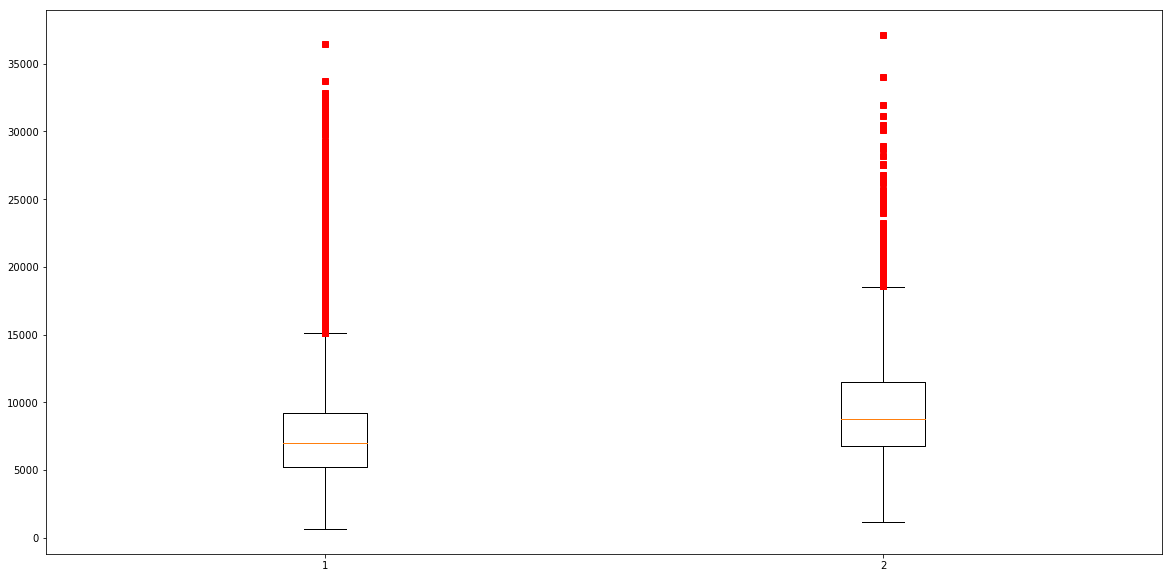

In [19]:
data_tomorrow_no_holiday = _trainData[_trainData["isTomorrowHoliday"] == 0].Sales.as_matrix()
data_tomorrow_holiday = _trainData[_trainData["isTomorrowHoliday"] == 1].Sales.as_matrix()
pl.figure(figsize=(20,10))

pl.boxplot([x for x in [data_tomorrow_no_holiday, data_tomorrow_holiday]], 0, 'rs', 1)
pl.show()

If there is a holiday tomorrow, the sales to day seems to be higher

In [20]:
# Feature 9: Median sales for holiday that is between the current day
tomorrowHolidayMedian = _trainData.groupby("isTomorrowHoliday").Sales.median()
yesterdayHolidayMedian = _trainData.groupby("isYesterdayHoliday").Sales.median()
def getTomorrowHolidayMedian(row):
    return tomorrowHolidayMedian.iloc[row["isTomorrowHoliday"]]
def getYesterdayHolidayMedian(row):
    return yesterdayHolidayMedian.iloc[row["isTomorrowHoliday"]]
_trainData["tomorrow_holiday_median"] = _trainData.apply(lambda row: getTomorrowHolidayMedian(row), axis=1)
_trainData["yesterday_holiday_median"] = _trainData.apply(lambda row: getYesterdayHolidayMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["tomorrow_holiday_median"] = _trainData["tomorrow_holiday_median"]
feature_list["yesterday_holiday_median"] = _trainData["yesterday_holiday_median"]

## Feature 10: Median sales of promotion 2
We are also provided details of the promotion cycle

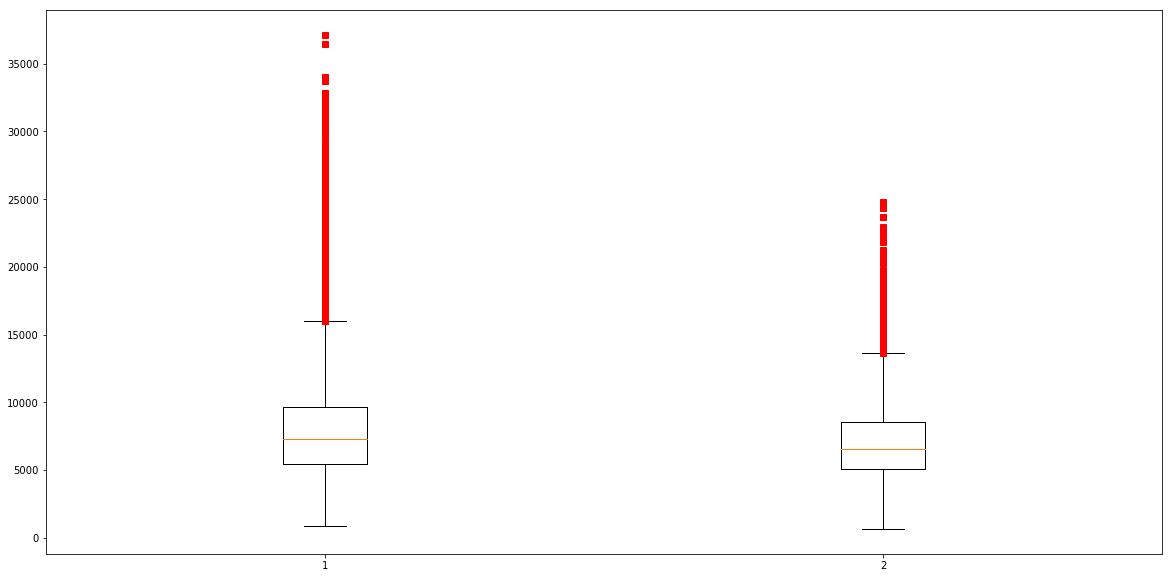

In [21]:
month_num_name_dict = {
    "1": "Jan",
    "2": "Feb",
    "3": "Mar",
    "4": "Apr",
    "5": "May",
    "6": "Jun",
    "7": "Jul",
    "8": "Aug",
    "9": "Sept",
    "10": "Oct",
    "11": "Nov",
    "12": "Dec"
}
def isHavingPromo2(row):
    if not isinstance(row['PromoInterval'], str):
        return 0
    elif month_num_name_dict[str(row['Date'].to_pydatetime().month)] in row['PromoInterval']:
        return 1
    else:
        return 0
_trainData = pd.DataFrame()
_trainData['having_promo_2'] = trainData.apply(lambda row: isHavingPromo2(row), axis=1)
_trainData["Sales"] = trainData["Sales"]
data_not_having_promo = _trainData[_trainData["having_promo_2"] == 0].Sales.as_matrix()
data_having_promo = _trainData[_trainData["having_promo_2"] == 1].Sales.as_matrix()
pl.figure(figsize=(20,10))

pl.boxplot([x for x in [data_not_having_promo, data_having_promo]], 0, 'rs', 1)
pl.show()

There is very little difference with promotion 2 too

In [22]:
# Feature 10: Promo 2
havingPromo2Median = _trainData.groupby("having_promo_2").Sales.median()
def promo2Median(row):
    return havingPromo2Median.iloc[row["having_promo_2"]]
_trainData['promo_2_median'] = _trainData.apply(lambda row: promo2Median(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["promo_2_median"] = _trainData["promo_2_median"]

## Feature 11: Day of Month Median
We check if there is any relations of median sales regarding to the day of month

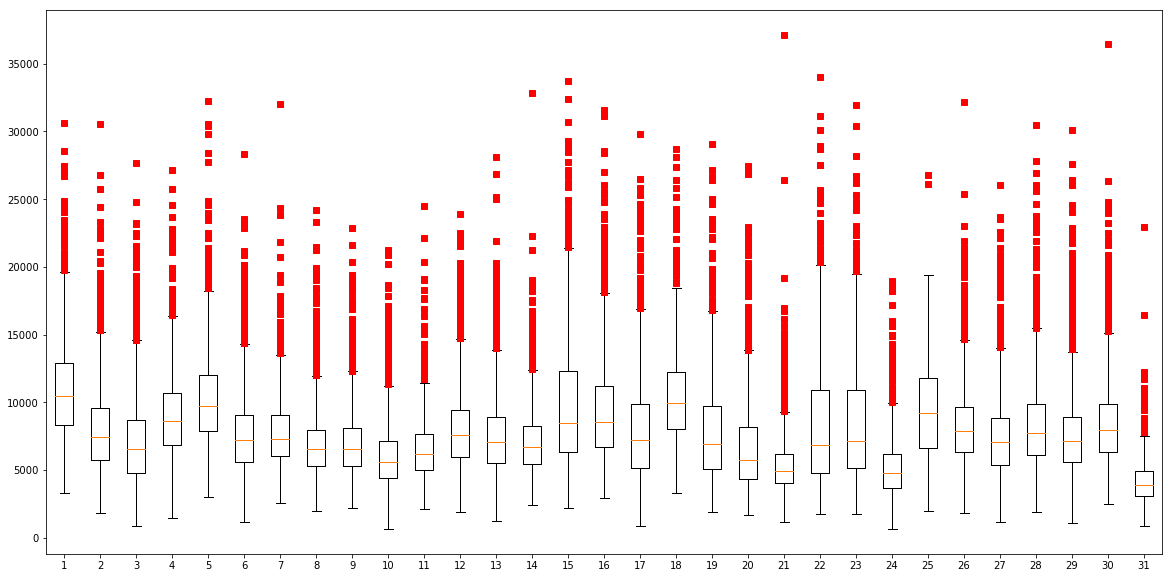

In [23]:
def dayOfMonth(row):
    return str(row['Date']).split('-')[2].split(' ')[0]
def dayOfMonthInt(row):
    return int(row["dayOfMonth"])
def getDayOfMonthMedian(row):
    return dayOfMonthSalesMedian[row['dayOfMonth']]
_trainData = pd.DataFrame()
_trainData["Sales"] = trainData["Sales"]
_trainData["dayOfMonth"] = trainData.apply(lambda row: dayOfMonth(row), axis=1)
_trainData["dayOfMonthInt"] = _trainData.apply(lambda row: dayOfMonthInt(row), axis=1)
data = []
for i in range(31):
    data.append(_trainData[_trainData["dayOfMonthInt"] == i + 1].Sales.as_matrix())
pl.figure(figsize=(20,10))

pl.boxplot([x for x in data], 0, 'rs', 1)
pl.show()

It seems that there is difference between the sales and day of month.

In [24]:
# Feature 11: Day Of Month Median
# dayOfMonthSalesMedian = _trainData.groupby("dayOfMonth").Sales.median()
# _trainData['getDayOfMonthMedian'] = _trainData.apply(lambda row: getDayOfMonthMedian(row), axis=1)
# _trainData.index = range(len(_trainData))
# feature_list["day_of_month_median"] = _trainData['getDayOfMonthMedian']

However, after experimentation, we commented this out because this has resulted in an overfit.

# Using Linear Regression
The features we gathered tells us something about the sales one way or another. To predict the sales, we can use a linear regression to do fitting

In [25]:
X = feature_list
y = trainData.Sales.values.reshape(-1,1)
lr = LinearRegression()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
clf = lr.fit(X_train,y_train)
print("Cross validation score: " + str(clf.score(X_val, y_val)))

Cross validation score: 0.823734196695


As we can see, linear regression is very weak to model something that is as complex as time series

# Using Random Forest Regressor
Some features are more important than others. We need trees to help us figure out which is more important than others. Hence, we also try out RandomForestRegressor

In [26]:
X = feature_list
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
rfr = RandomForestRegressor(n_estimators=8)
clf = rfr.fit(X_train, y_train)
print("Cross validation score: " + str(clf.score(X_val, y_val)))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Cross validation score: 0.914403549155


We found out that random tree regressor is able to pick up important features, and hence perform better than linear regression

# Using XGBoost
According to research, `xgboost`, a gradient boosting tree is very good in doing predictions. We'll check how this compares to other models

Cross validation score: 0.953070473702


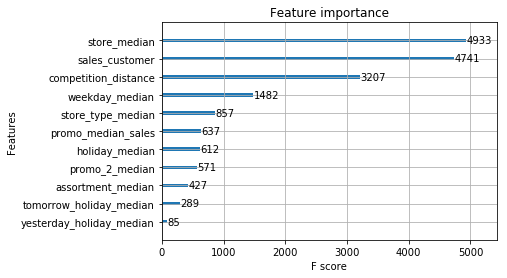

In [27]:
X = feature_list
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
xgb = XGBRegressor(learning_rate=0.3, subsample=0.75, colsample_bytree=0.75, max_depth=8, gamma=1)
clf = xgb.fit(X_train, y_train, eval_metric="rmse")
print("Cross validation score: " + str(clf.score(X_val, y_val)))
xgboost.plot_importance(xgb).figure

It seems that xgboost is a lot more better in our case. From the feature importance table, we know that customers influence our prediction the most, followed by store median, competition distance.

## Manipulating test data
`testFeatureList` is the dataframe to store all the test features so that test data is not contaminated

In [28]:
testFeatureList = pd.DataFrame()

We do all the manipulation to pul out all the important features.
Note that we commented out `day_of_month_median` to prevent overfitting.

In [29]:
X = testData.Customers.values.reshape(-1,1)
df = pd.DataFrame(sales_customer_lr.predict(X))
testFeatureList["sales_customer"] = df[0]
testFeatureList["store_median"] = testData.apply(lambda row: getMedianOfStore(row), axis=1)
_testData = pd.DataFrame()
_testData["Weekday"] = testData.apply(lambda row: getWeekDay(row), axis=1)
_testData["weekday_median"] = _testData.apply(lambda row: getWeekDayMedian(row), axis=1)
testFeatureList["weekday_median"] = _testData["weekday_median"]
_testData = pd.DataFrame()
_testData["promo_median_sales"] = testData.apply(lambda row: getPromoMedian(row), axis=1)
testFeatureList["promo_median_sales"] = _testData["promo_median_sales"]
_testData = pd.DataFrame()
_testData["store_type_median"] = testData.apply(lambda row: getStoreTypeMedian(row), axis=1)
testFeatureList["store_type_median"] = _testData["store_type_median"]
_testData = pd.DataFrame()
_testData["assortment_median"] = testData.apply(lambda row: getAssortmentMedian(row), axis=1)
testFeatureList["assortment_median"] = _testData["assortment_median"]
testFeatureList["competition_distance"] = testData["CompetitionDistance"]
testFeatureList.fillna(0, inplace=True)
_testData = pd.DataFrame()
_testData["Holiday"] = testData.apply(lambda row: hasHoliday(row), axis=1)
_testData["holiday_median"] = _testData.apply(lambda row: getHolidayMedian(row), axis=1)
testFeatureList["holiday_median"] = _testData["holiday_median"]
_testData = pd.DataFrame()
_testData["Holiday"] = testData.apply(lambda row: hasHoliday(row), axis=1)
_testData["Date"] = testData["Date"]
_testData['previousRowDate'] = _testData['Date'].shift(1)
_testData['nextRowDate'] = _testData['Date'].shift(-1)
_testData['isTomorrowHoliday'] = _testData['Holiday'].shift(1)
_testData['isYesterdayHoliday'] = _testData['Holiday'].shift(-1)
_testData['isTomorrowHoliday'] = _testData.apply(lambda row: isTomorrowHoliday(row), axis=1)
_testData['isYesterdayHoliday'] = _testData.apply(lambda row: isYesterdayHoliday(row), axis=1)
_testData["tomorrow_holiday_median"] = _testData.apply(lambda row: getTomorrowHolidayMedian(row), axis=1)
_testData["yesterday_holiday_median"] = _testData.apply(lambda row: getYesterdayHolidayMedian(row), axis=1)
testFeatureList["tomorrow_holiday_median"] = _testData["tomorrow_holiday_median"]
testFeatureList["yesterday_holiday_median"] = _testData["yesterday_holiday_median"]
_testData = pd.DataFrame()
_testData['having_promo_2'] = testData.apply(lambda row: isHavingPromo2(row), axis=1)
_testData['promo_2_median'] = _testData.apply(lambda row: promo2Median(row), axis=1)
_testData.index = range(len(_testData))
testFeatureList["promo_2_median"] = _testData["promo_2_median"]
# _testData = pd.DataFrame()
# _testData["dayOfMonth"] = testData.apply(lambda row: dayOfMonth(row), axis=1)
# _testData['getDayOfMonthMedian'] = _testData.apply(lambda row: getDayOfMonthMedian(row), axis=1)
# testFeatureList["day_of_month_median"] = _testData['getDayOfMonthMedian']

Use the trained xgboost to predict test data

In [30]:
results = xgb.predict(testFeatureList)

Writing it into the submission files

In [31]:
store_closed_index = np.where(testData.Customers == 0)
for val in store_closed_index:
    results[val] = 1
with open('submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'Sales']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for idx, val in enumerate(results):
        writer.writerow({'Id': index[idx] + 1, 'Sales': val})
    csvfile.close()